# Determining Antoine's Coefficients

Teng-Jui Lin

Content adapted from UW CHEME 375, Chemical Engineering Computer Skills, in Spring 2021.

- Python skills and numerical methods
  - Solving nonlinear systems
  - Control flow
  - Curve fitting
- ChemE applications
  - Determine Antoine's coefficients
  - x/y diagrams
  - Txy diagrams

## Determine Antoine's coefficients

**Problem Statement.** Compounds A and B with unknown Antoine's coefficients are in binary vapor liquid equilibrium at a pressure of 1 atm. The experimental data are

- `x_A = [0, 0.1, ..., 1.0]`
- `y_A = [0, 0.401, 0.639, 0.704, 0.798, 0.855, 0.871, 0.907, 0.948, 0.959, 1.0]`

(a) Assuming ideal gas and solution behavior, determine the Antoine's coefficients of A and B using the form

$$
\ln P^* = A - \dfrac{B}{C+T}
$$

where $P$ has a unit of kPa, and $T$ has a unit of $\mathrm{^\circ C}$. Note that many sets of coefficients could give good fit to the data, but prior experience with this family of compounds suggests the following initial guesses:

|Compound|A|B|C|
|-:|-:|-:|-:|
|A|14|2800|250|
|B|15|3000|200|

(b) Generate an x/y diagram and a Txy diagram for the methanol-ethanol system.

**Solution.** Assuming ideal behavior, Raoult's law states that the partial pressure of one component is equal to the vapor pressure of the component times its liquid mole fraction

$$
P_i = y_i P = x_i P_i^*(T)
$$

where the vapor pressure can be determined by the given Antoine's equation form

$$
\ln P_i^*(T) = A - \dfrac{B}{T+C}.
$$

We use given $x_A$ to solve for theoretical $y_A$ using guesses of Antoine's coefficients, and compare with experimentally-obtained $y_A$. The best Antoine's coefficients should have a minimum sum of squared residual (SSR) when comparing theoretical and experimental $y_A$:

$$
\mathrm{SSR} = \sum (\mathrm{Res})^2 = \sum_{i=1}^n (y_{A, \text{theoretical}, i} - x_{\text{data}, i})^2
$$

### Known values

- Units of values in Antoine's equation
    - P [=] kPa
    - T [=] deg C
- Known liquid and vapor composition
    - $x_A$ from given experimental data
    - $y_A$ NOT known
      - although given experimental values, here we're finding theoretical values
- Known pressure
    - $P = 1 \ \mathrm{atm}$

### Fitting parameters (find by `minimize()`)

- Antoine's coefficients of A and B: $A_A, B_A, C_A, A_B, B_B, C_B$
  - Given initial guesses

|Compound|A|B|C|
|-:|-:|-:|-:|
|A|14|2800|250|
|B|15|3000|200|

### Unknown variables (find by `fsolve()`)

- Composition of liquid phase: $x_B$
- Composition of vapor phase: $y_A$, $y_B$
- Temperature: $T$

### Governing equations
The raw equations are:
- Raoult's law and Antoine's equation
    - $y_A P = x_A P_A^*(T) = x_A \exp(A_A - \frac{B_A}{C_A+T})$
    - $y_B P = x_B P_B^*(T) = x_B \exp(A_B - \frac{B_B}{C_B+T})$
- conservation of mass (mole, since nonreactive)
    - $y_A + y_B = 1$
    - $x_A + x_B = 1$

Convert all the equations so they're in the general form of $F(x) = 0$:
- Raoult's law and Antoine's equation
    - $y_A P - x_A \exp(A_A - \frac{B_A}{C_A+T}) = 0$
    - $y_B P - x_B \exp(A_B - \frac{B_B}{C_B+T}) = 0$
- conservation of mass
    - $1 - y_A - y_B = 0$
    - $1 - x_A - x_B = 0$

We can now solve the four nonlinear equations with respect to the four unknown variables given the known values at each $x_M$ experimental data point using control flow loop. The theoretical $y_A$ is then compared with experimentally-obtained $y_A$ by SSR.

### Implementation

In this approach, we use [`scipy.optimize.fsolve()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html) to solve the nonlinear system directly at each $x_A$. We use a for loop to iterate through the experimental data points of $x_A$.

We then use [`scipy.optimize.minimize()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) to find the set of Antoine's coefficients that gives the lowest SSR.

In [1]:
import numpy as np
from scipy.optimize import fsolve
from scipy.optimize import fmin
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
def system(X, params):
    '''System of nonlinear equations'''
    # X -> unknown variables
    # params -> known values
    xb, ya, yb, T = X
    xa, P, Aa, Ba, Ca, Ab, Bb, Cb = params
    # set up system of equations
    eqns = np.array([
        ya*P - xa*np.e**(Aa - Ba/(Ca + T)),
        yb*P - xb*np.e**(Ab - Bb/(Cb + T)),
        1 - ya - yb,
        1 - xa - xb
    ])
    return eqns

In [3]:
# define given experimental data
xa_exp = np.arange(0, 1.1, 0.1)
ya_exp = np.array([0, 0.401, 0.639, 0.704, 0.798, 0.855, 0.871, 0.907, 0.948, 0.959, 1.0])

In [4]:
# initial guess of system
X0 = [0.5, 0.5, 0.5, 50]

In [5]:
# given initial guesses of Antoine's coeff
antoine_coeffs_0 = np.array([15, 2500, 200, 15, 3000, 200])

In [6]:
P = 1 * 101.325 # atm -> kPa

In [7]:
def VLE(system, X0, xa, P, antoine_coeffs):
    '''
    Iterate to find the theoretical yb (along with other var) 
    for each guess of Antoines coefficients
    '''
    xa_len = len(xa)
    xb = np.zeros(xa_len)
    ya = np.zeros(xa_len)
    yb = np.zeros(xa_len)
    T = np.zeros(xa_len)
    
    for i in range(xa_len):
        params = [xa[i], P, *antoine_coeffs]
        xb[i], ya[i], yb[i], T[i] = fsolve(system, X0, params)
    return xb, ya, yb, T

In [8]:
def SSR(antoine_coeffs, system, X0, xa, P):
    ya = VLE(system, X0, xa, P, antoine_coeffs)[1]
    ssr = np.sum((ya - ya_exp)**2)
    return ssr

In [9]:
xa = np.arange(0, 1.02, 0.02)
res = minimize(SSR, antoine_coeffs_0, args=(system, X0, xa_exp, P))
antoine_coeffs_minimize = res.x
antoine_coeffs_minimize

array([  16.18438949, 2501.42874749,  172.76695042,   14.12238484,
       2998.80931298,  227.23357737])

In [10]:
xb_minimize, ya_minimize, yb_minimize, T_minimize = VLE(system, X0, xa, P, antoine_coeffs_minimize)

Using `minimize()`, we found the Antoine's coefficients are as follows:

|Compound|A|B|C|
|-:|-:|-:|-:|
|A|16.18439|2501.429|172.7670|
|B|14.12238|2998.809|227.2336|

which are close to our initial guesses.

**Note.** If `fmin()` is used instead of `minimize()`, it may not give good Antoine's coefficients, even though their VLE diagrams may look similar. `fmin()` is sensitive to initial guesses. The following demonstrates that one should NOT use `fmin()` in this case:

In [11]:
# do NOT use fmin (demo)
xa = np.arange(0, 1.02, 0.02)
antoine_coeffs_fmin = fmin(SSR, antoine_coeffs_0, args=(system, X0, xa_exp, P), maxiter=1e5, maxfun=1e5)
antoine_coeffs_fmin

C:\Softwares\Anaconda\Anaconda\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Softwares\Anaconda\Anaconda\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
C:\Softwares\Anaconda\Anaconda\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


Optimization terminated successfully.
         Current function value: 0.002733
         Iterations: 567
         Function evaluations: 1007


array([  15.28095414, 3393.4707803 ,  231.70952711,   13.79716241,
       4567.9164073 ,  338.53386793])

The `fmin()` function raises warnings that the tolerance has not been reached, having an SSR of 0.0027. The returned Antoine's coefficients are far from our initial guesses, therefore the result should not be used.

### VLE Diagrams

In [12]:
# plot settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams.update({
    'font.family': 'Arial',  # Times New Roman, Calibri
    'font.weight': 'normal',
    'mathtext.fontset': 'cm',
    'font.size': 18,
    
    'lines.linewidth': 2,
    
    'axes.linewidth': 2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.titleweight': 'bold',
    'axes.titlesize': 18,
    'axes.labelweight': 'bold',
    
    'xtick.major.size': 8,
    'xtick.major.width': 2,
    'ytick.major.size': 8,
    'ytick.major.width': 2,
    
    'figure.dpi': 80,
    
    'legend.framealpha': 1, 
    'legend.edgecolor': 'black',
    'legend.fancybox': False,
    'legend.fontsize': 14
})

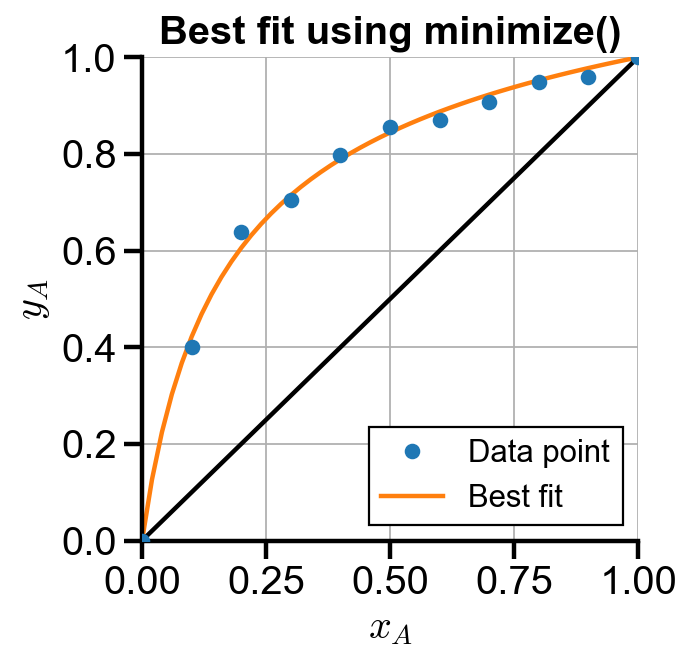

In [13]:
# x/y diagram
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(xa_exp, ya_exp, 'o', label='Data point', zorder=3)
ax.plot(xa, ya_minimize, label='Best fit')
ax.plot([0, 1], [0, 1], color='black')
ax.set_xlabel('$x_A$')
ax.set_ylabel('$y_A$')
ax.set_title('Best fit using minimize()')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend()
ax.grid(True)

Text(0.3, 57, 'Two-phase')

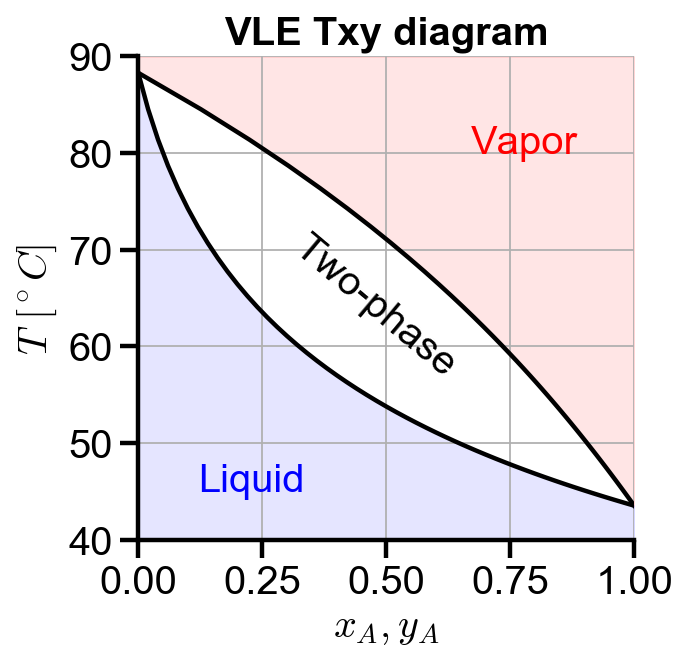

In [14]:
# main Txy diagram
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(xa, T_minimize, color='black')
ax.plot(ya_minimize, T_minimize, color='black')
ax.set_xlabel('$x_A, y_A$')
ax.set_ylabel('$T \ [^\circ C]$')
ax.set_title('VLE Txy diagram')
ax.set_xlim(0, 1)
ymin = 40
ymax = 90
ax.set_ylim(ymin, ymax)
ax.grid(True)

# colored phase regions
ax.fill_between(xa, ymin, T_minimize, color='blue', alpha=0.1)
ax.fill_between(ya_minimize, T_minimize, ymax, color='red', alpha=0.1)
ax.text(0.12, 45, 'Liquid', color='blue')
ax.text(0.67, 80, 'Vapor', color='red')
ax.text(0.3, 57, 'Two-phase', color='black', rotation=-40)